ITD_VARIABILLITIES_OVER_WEST_AFRICA
=
===========================================================================

----

### IMPORTING LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy import feature as cf
from cartopy.feature import BORDERS
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

### READING DATASETS

In [3]:
path = ('E:/DATASETS/ERA5/')     #folder

In [4]:
ds_rh = xr.open_dataset(path + 'Relative_humidity_1981_2020.nc')   # RH data
ds_dewpoint = xr.open_dataset(path + '2m_Dewpoint_1991_2020.nc')   # Dewpoint 
ds_winds = xr.open_dataset(path + 'Winds_1981_2020.nc')            #winds data
ds_TP = xr.open_dataset(path + 'Total_precip_1981_2020.nc')        #total precipitation

In [5]:
#ds_rh
#ds_dewpoint
#ds_winds
#ds_TP

#### CHANGING THE UNIT OF PRECIP FROM METRES TO MILLIMETERS

In [6]:
ds_tp =ds_TP*1000
ds_tp.attrs["units"] = "millimeter "


### GROUPING THE DATASET INTO SEASONS AND MONTHS

In [7]:
mon_dewpoint = ds_dewpoint.groupby('time.month').mean('time')
seas_dewpoint = ds_dewpoint.groupby('time.season').mean('time')

In [8]:
mon_rh = ds_rh.groupby('time.month').mean()
seas_rh = ds_rh.groupby('time.season').mean()

In [9]:
mon_tp = ds_tp.tp.groupby('time.month').sum('time')
seas_tp = ds_tp.tp.groupby('time.season').sum('time')

### CHANGE THE DEWPOINT FROM KELVIN TO CELSIUS

In [10]:
def celsius(data):
    C = data -273.15
    return C

In [11]:
mon_dewpoint_c = celsius(mon_dewpoint)
seas_dewpoint_c = celsius(seas_dewpoint)

### ITD_POSITION FUNCTION

In [12]:
class ITD:
    def dewpoint(data):
        I = data.where(data > 15)
        II = I.where(I <17)
        return II
    
    def rh(data):
        I = data.where(data > 40)
        II = I.where(I < 50)
        return II

### ITD FILES

In [13]:
mon_itd_rh = ITD.rh(mon_rh)
seas_itd_rh = ITD.rh(seas_rh)

mon_itd_dewpoint = ITD.dewpoint(mon_dewpoint_c)
seas_itd_dewpoint = ITD.dewpoint(seas_dewpoint_c)

#### RH FILES

In [14]:
rh_itd_mon = mon_itd_rh.r
rh_itd_seas = seas_itd_rh.r

#### DEWPOINT FILES

In [15]:
dewpoint_itd_mon = mon_itd_dewpoint.d2m
dewpoint_itd_seas = seas_itd_dewpoint.d2m

## WIND SPEED & DIRECTION 

#### SELECTING THE U & V COMPONENTS 

In [16]:
u_component = ds_winds.u10
v_component = ds_winds.v10

#### CALCULATING THE WIND SPEED

In [17]:
%%time

wind_speed = np.sqrt(u_component**2 + v_component**2)

Wall time: 37.3 s


#### CALCULATING THE WIND DIRECTION

In [18]:
%%time
wind_direction = np.mod(180+np.rad2deg(np.arctan2(u_component, v_component)), 360)

Wall time: 4.81 s


#### GROUPING THE WIND FILES INTO SEASON AND MONTHS

In [19]:
#wind direction
wind_direction_mon = wind_direction.groupby('time.month').mean('time')
wind_direction_seas = wind_direction.groupby('time.season').mean('time')

#wind speed
wind_speed_mon = wind_speed.groupby('time.month').mean('time')
wind_speed_seas = wind_speed.groupby('time.season').mean('time')

#u,v components
u_mon = u_component.groupby('time.month').mean('time')
v_mon = v_component.groupby('time.month').mean('time')

u_seas = u_component.groupby('time.season').mean('time')
v_seas = v_component.groupby('time.season').mean('time')



#### SELECTING SOME LONGITUDES AND LATITUDES 

In [20]:
# Each file has latitude:65, longitude: 137 so I am selecting 
# latitude:7 longitude:10

# wind direction
wind_direction_seas = wind_direction_seas[::,::10,::15] 
wind_direction_mon = wind_direction_mon[::,::10,::15]


# u, v components
u_comp_seas = u_seas[::,::10,::15] 
v_comp_seas = v_seas[::,::10,::15]

u_comp_mon = u_mon[::,::10,::15]
v_comp_mon = v_mon[::,::10,::15]

### SEASONAL PLOT OF THE ITD

#### WITHOUT RAINFALL PLOT

Text(0.5, 0.98, 'SEASONAL INTER-TROPICAL DISCONTINUITY (ITD) POSITION')

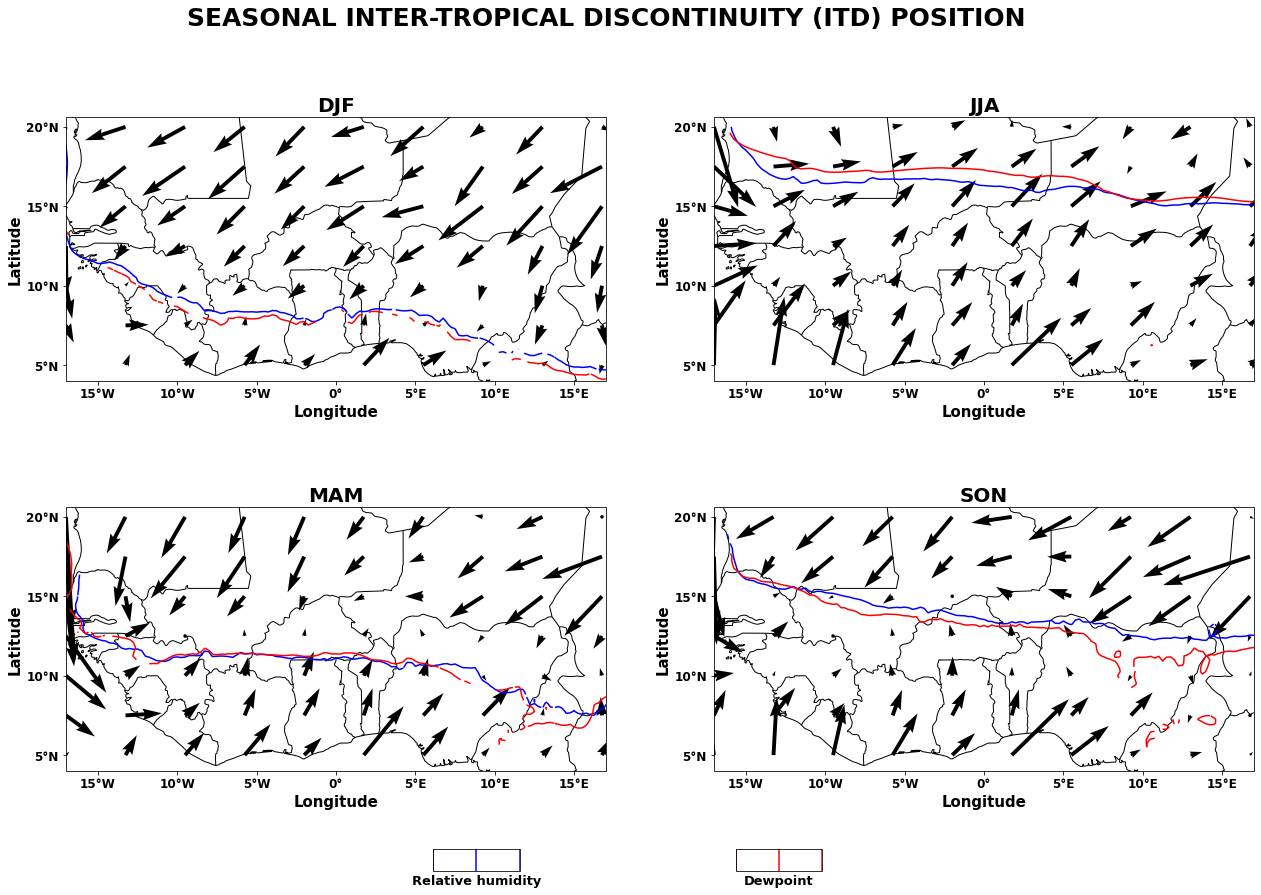

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw = dict(projection = ccrs.PlateCarree()), 
                         figsize=(20,15), sharex = False, sharey = False)
plt.subplots_adjust(bottom=0.25, right=0.95, top=0.9, hspace = 0.25)


ax = axes.flatten()

Titles = ['DJF', 'JJA', 'MAM', 'SON']
xlabels = (['-15','-10','-5','0','5','10','15'])
ylabels = (['20','15','10','5'])

for i, a in enumerate(ax):
    
    ax[i].coastlines()
    ax[i].add_feature(cf.BORDERS)
    ax[i].set_extent([-17, 17, 4,20])
    ax[i].set_xticks([-15,-10,-5,0,5,10,15],  crs=ccrs.PlateCarree()) 
    ax[i].set_yticks([20,15,10,5], crs=ccrs.PlateCarree())
    ax[i].set_title(Titles[i], fontsize = 20, fontweight = 'bold')
    

    ax[i].set_xticklabels(xlabels, fontsize = 12, fontweight = 'bold')
    ax[i].set_yticklabels(ylabels, fontsize = 12, fontweight = 'bold')
    
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax[i].xaxis.set_major_formatter(lon_formatter)
    ax[i].yaxis.set_major_formatter(lat_formatter)
    
    ax[i].set_xlabel('Longitude', fontsize = 15, fontweight = 'bold')
    ax[i].set_ylabel('Latitude', fontsize = 15, fontweight = 'bold')
    
    

    
    #plotting the wind direction
    ww = ax[i].quiver(wind_direction_seas[i]['longitude'], wind_direction_seas[i]['latitude'], u_comp_seas[i], v_comp_seas[i])
    
    #plotting the ITD (Rel. Humidity)
    rh=ax[i].contour(rh_itd_seas['longitude'], rh_itd_seas['latitude'], rh_itd_seas[i],1,
                      transform=ccrs.PlateCarree(), colors=['b'])
    
    #plotting the ITD (Dewpoint)
    dp=ax[i].contour(dewpoint_itd_seas['longitude'], dewpoint_itd_seas['latitude'], dewpoint_itd_seas[i],1,
                      transform=ccrs.PlateCarree(), colors = ['r'])
    
cbar_rh = fig.add_axes([0.38, 0.18, 0.06, 0.02])
cbar_dp = fig.add_axes([0.59, 0.18, 0.06, 0.02])

cbar1=fig.colorbar(rh, cax=cbar_rh, orientation='horizontal')
cbar1.ax.tick_params(size=0)
cbar1.set_ticks([])
cbar1.set_label( label = 'Relative humidity',size=13,weight='bold')

cbar2=fig.colorbar(dp, cax=cbar_dp, orientation='horizontal')
cbar2.ax.tick_params(size=0)
cbar2.set_ticks([])
cbar2.set_label( label = 'Dewpoint',size=13,weight='bold')
    
fig.suptitle('SEASONAL INTER-TROPICAL DISCONTINUITY (ITD) POSITION', fontsize =25, fontweight = 'bold')


#plt.savefig('seasonal_itd.pdf', dpi = 100)
#plt.savefig('seasonal_itd.png', dpi = 100)
#plt.savefig('seasonal_itd.jpg', dpi = 100)

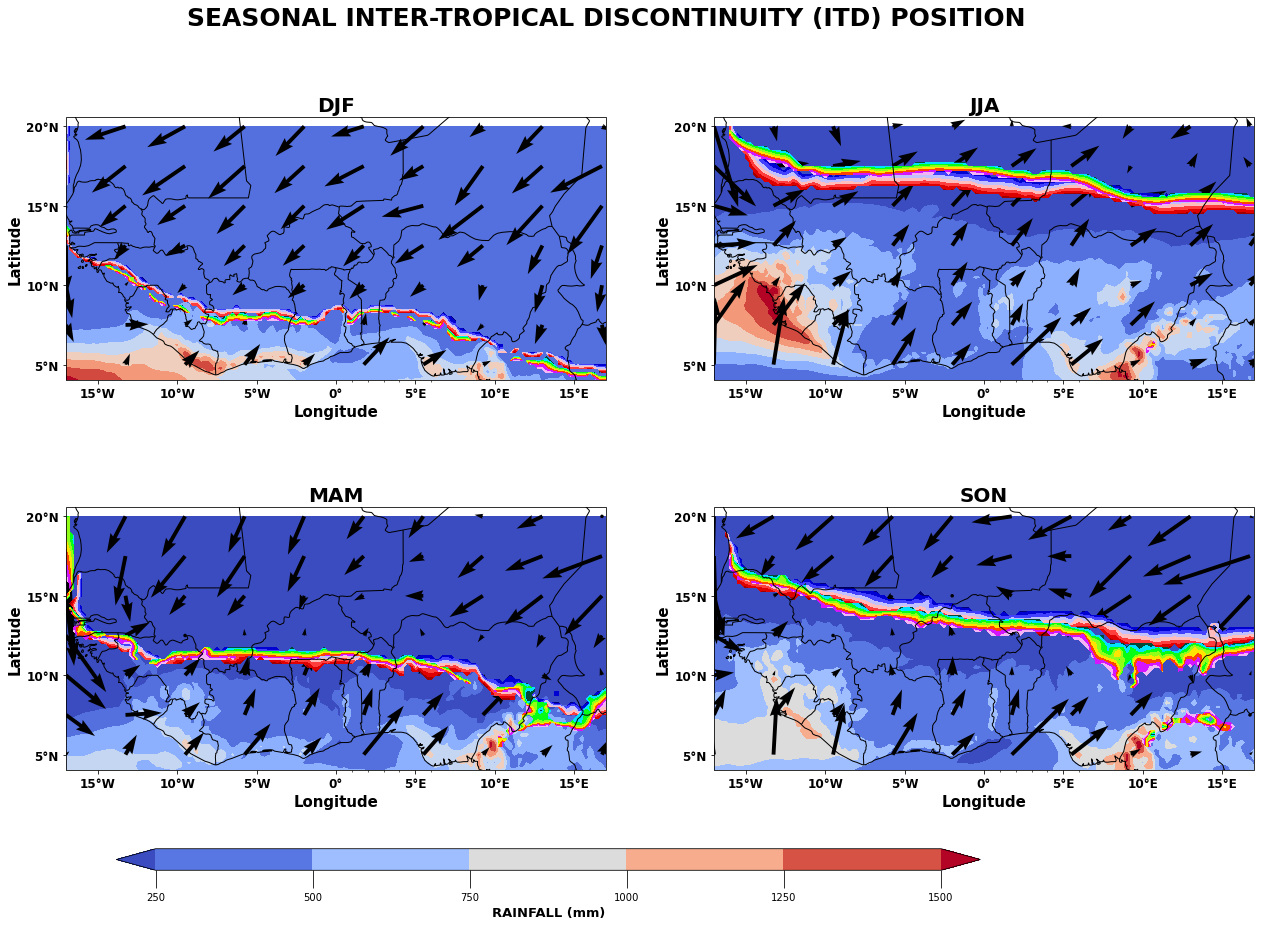

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw = dict(projection = ccrs.PlateCarree()), 
                         figsize=(20,15), sharex = False, sharey = False)
plt.subplots_adjust(bottom=0.25, right=0.95, top=0.9, hspace = 0.25)


ax = axes.flatten()

Titles = ['DJF', 'JJA', 'MAM', 'SON']
xlabels = (['-15','-10','-5','0','5','10','15'])
ylabels = (['20','15','10','5'])

for i, a in enumerate(ax):
    
    ax[i].coastlines()
    ax[i].add_feature(cf.BORDERS)
    ax[i].set_extent([-17, 17, 4,20])
    ax[i].set_xticks([-15,-10,-5,0,5,10,15],  crs=ccrs.PlateCarree()) 
    ax[i].set_yticks([20,15,10,5], crs=ccrs.PlateCarree())
    ax[i].set_title(Titles[i], fontsize = 20, fontweight = 'bold')
    
    ax[i].set_xticks(np.arange(1,7),1)
    ax[i].set_xticklabels(xlabels, fontsize = 12, fontweight = 'bold')
    
    #ax[i].set_yticks(np.arange(1,4),1)
    ax[i].set_yticklabels(ylabels, fontsize = 12, fontweight = 'bold')
    
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax[i].xaxis.set_major_formatter(lon_formatter)
    ax[i].yaxis.set_major_formatter(lat_formatter)
    
    ax[i].set_xlabel('Longitude', fontsize = 15, fontweight = 'bold')
    ax[i].set_ylabel('Latitude', fontsize = 15, fontweight = 'bold')
    
    
    
   
    #plotting the rainfall data
    p=ax[i].contourf(seas_tp['longitude'], seas_tp['latitude'], seas_tp[i],
                      transform=ccrs.PlateCarree(), cmap='coolwarm', extend = 'both')
     #tp = seas_tp[i].plot(cmap='bwr', ax = ax[i],vmax = 1500, vmin = 50 , add_colorbar = False)
    
    #plotting the wind direction
    ww = ax[i].quiver(wind_direction_seas[i]['longitude'], wind_direction_seas[i]['latitude'], u_comp_seas[i], v_comp_seas[i])
    
    #plotting the ITD (Rel. Humidity)
    rh=ax[i].contourf(rh_itd_seas['longitude'], rh_itd_seas['latitude'], rh_itd_seas[i],
                      transform=ccrs.PlateCarree(), cmap = 'seismic')
    
    #plotting the ITD (Dewpoint)
    dp=ax[i].contourf(dewpoint_itd_seas['longitude'], dewpoint_itd_seas['latitude'], dewpoint_itd_seas[i],
                      transform=ccrs.PlateCarree(), cmap = 'gist_ncar')
    
    
    
#axes[1,0].set_xlabel('Longitude', fontsize = 15, fontweight = 'bold')
#axes[1,1].set_xlabel('Longitude', fontsize = 15, fontweight = 'bold')
#axes[0,0].set_ylabel('Latitude', fontsize = 15, fontweight = 'bold')
#axes[1,0].set_ylabel('Latitude', fontsize = 15, fontweight = 'bold')

    
fig.suptitle('SEASONAL INTER-TROPICAL DISCONTINUITY (ITD) POSITION', fontsize =25, fontweight = 'bold')


cbar_ax = fig.add_axes([0.16, 0.18, 0.6, 0.02])
cbar=fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(size=18)
#cbar2.set_ticks([])
cbar.set_label( label = 'RAINFALL (mm)',size=13,weight='bold')

#plt.savefig('seasonal_itd+rainfall.pdf', dpi = 100)
#plt.savefig('seasonal_itd+rainfall.png', dpi = 100)
#plt.savefig('seasonal_itd+rainfall.jpg', dpi = 100)

### MONTHLY PLOTS

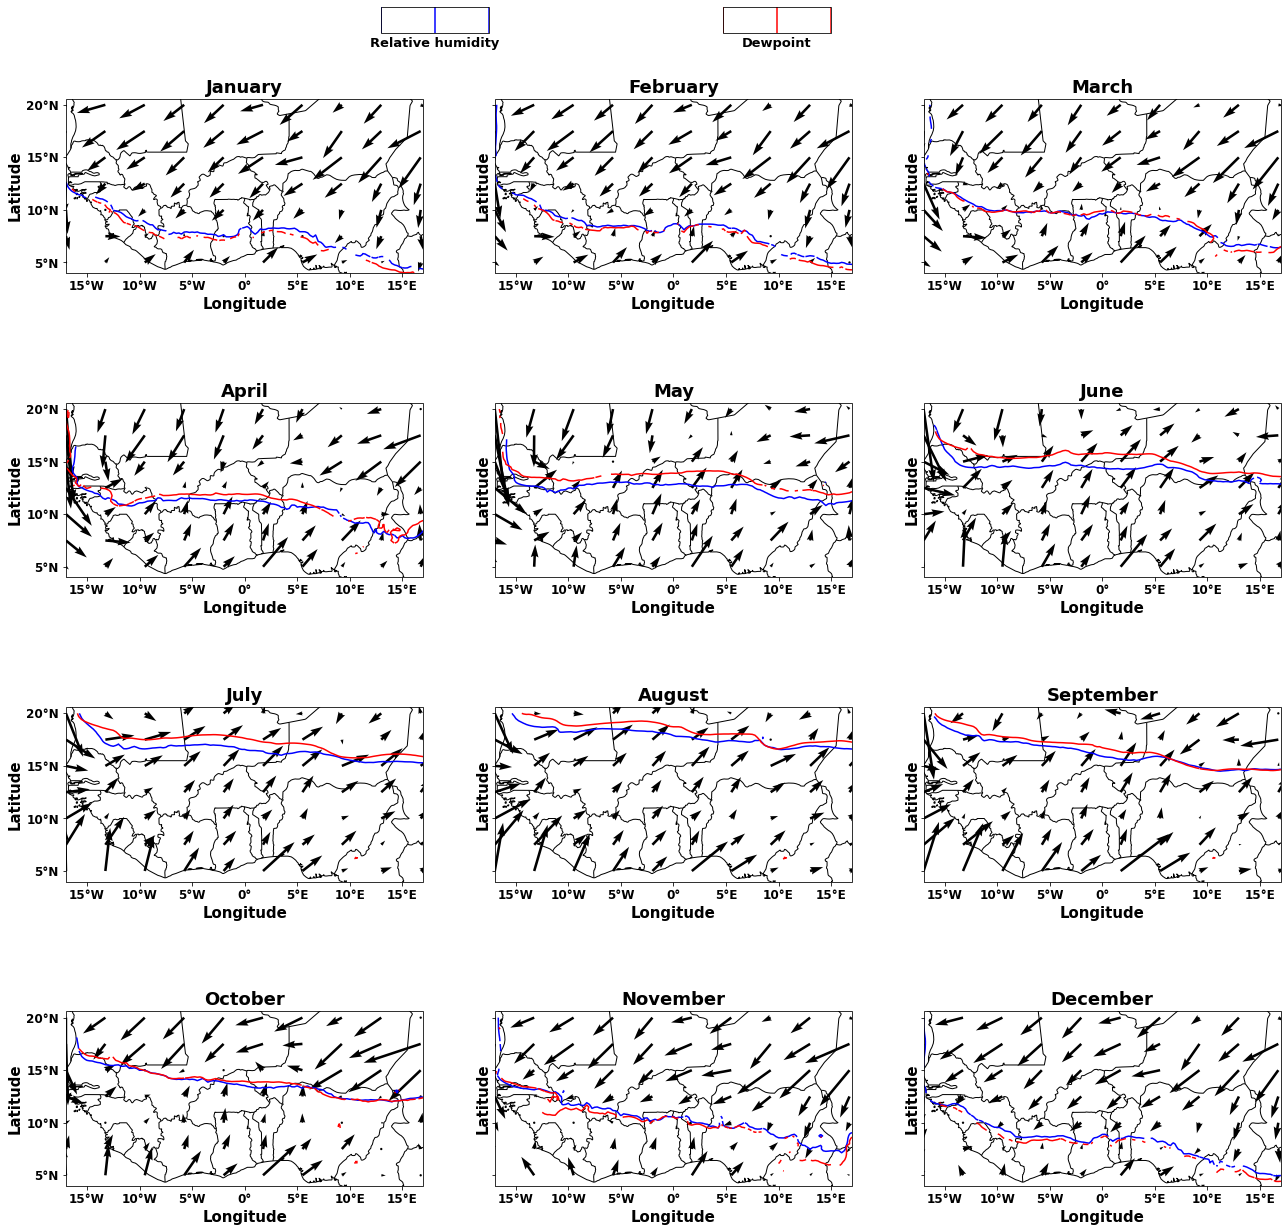

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=3, subplot_kw = dict(projection = ccrs.PlateCarree()), 
                         figsize=(25,18), sharex = False, sharey = True )
plt.subplots_adjust(bottom=0.05, right=0.8, top=0.95)

ax = axes.flatten()

month = month = ['January', 'February', 'March', 'April','May', 'June', 'July', 
                 'August', 'September', 'October','November', 'December']

xlabels = (['-15','-10','-5','0','5','10','15'])
ylabels = (['20','15','10','5'])

for i, a in enumerate(ax):   
    ax[i].coastlines()
    ax[i].add_feature(cf.BORDERS)
    ax[i].set_extent([-17, 17, 4,20])
    ax[i].set_xticks([-15,-10,-5,0,5,10,15],  crs=ccrs.PlateCarree()) 
    ax[i].set_yticks([20,15,10,5], crs=ccrs.PlateCarree())
    ax[i].set_title(month[i], fontsize = 18, fontweight = 'bold')
    ax[i].set_xlabel('Longitude', fontsize = 15, fontweight = 'bold')
    ax[i].set_ylabel('Latitude', fontsize = 15, fontweight = 'bold')
    
   
    ax[i].set_xticklabels(xlabels, fontsize = 12, fontweight = 'bold')
    
    
    ax[i].set_yticklabels(ylabels, fontsize = 12, fontweight = 'bold')
    
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax[i].xaxis.set_major_formatter(lon_formatter)
    ax[i].yaxis.set_major_formatter(lat_formatter)
    

    
    #plotting the wind direction
    ww = ax[i].quiver(wind_direction_mon[i]['longitude'], wind_direction_mon[i]['latitude'], u_comp_mon[i], v_comp_mon[i])
    
    
    #plotting the ITD (Rel. Humidity)
    rh=ax[i].contour(rh_itd_mon['longitude'], rh_itd_mon['latitude'], rh_itd_mon[i],1,
                      transform=ccrs.PlateCarree(), colors=['b'])
    
    #plotting the ITD (Dewpoint)
    dp=ax[i].contour(dewpoint_itd_mon['longitude'], dewpoint_itd_mon['latitude'], dewpoint_itd_mon[i],1,
                      transform=ccrs.PlateCarree(), colors=['r'])

cbar_rh = fig.add_axes([0.30, 0.97, 0.06, 0.02])
cbar_dp = fig.add_axes([0.49, 0.97, 0.06, 0.02])

cbar1=fig.colorbar(rh, cax=cbar_rh, orientation='horizontal')
cbar1.ax.tick_params(size=0)
cbar1.set_ticks([])
cbar1.set_label( label = 'Relative humidity',size=13,weight='bold')

cbar2=fig.colorbar(dp, cax=cbar_dp, orientation='horizontal')
cbar2.ax.tick_params(size=0)
cbar2.set_ticks([])
cbar2.set_label( label = 'Dewpoint',size=13,weight='bold')
   
#fig.suptitle('MONTHLY INTER-TROPICAL DISCONTINUITY (ITD) POSITION', fontsize =25, fontweight = 'bold')        
    
                      
#plt.savefig('monthly_itd.pdf', dpi = 100)
#plt.savefig('monthly_itd.png', dpi = 100)
#plt.savefig('monthly_itd.jpg', dpi = 100)

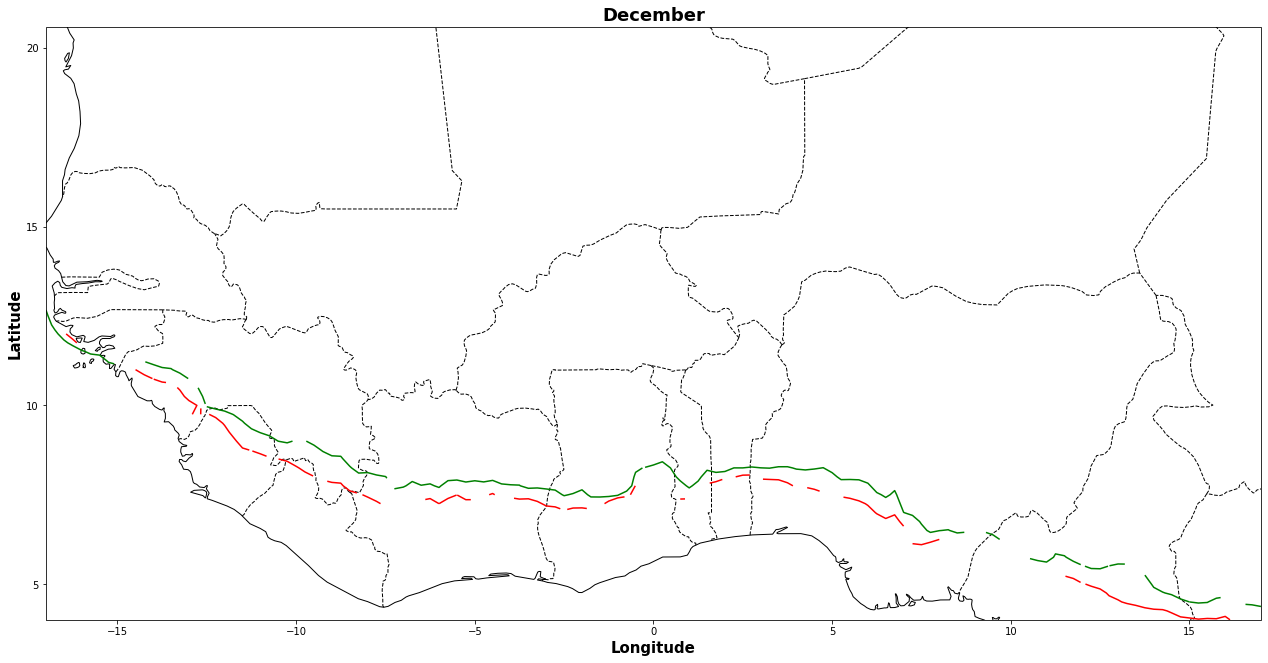

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw = dict(projection = ccrs.PlateCarree()), 
                         figsize=(25,18), sharex = False, sharey = True )
plt.subplots_adjust(bottom=0.05, right=0.8, top=0.95)

ax = axes

month = month = ['January', 'February', 'March', 'April','May', 'June', 'July', 
                 'August', 'September', 'October','November', 'December']

xlabels = (['-15','-10','-5','0','5','10','15'])
ylabels = (['20','15','10','5'])

ax.coastlines()
ax.add_feature(cf.BORDERS,linestyle='--')
ax.set_extent([-17, 17, 4,20])
ax.set_xticks([-15,-10,-5,0,5,10,15],  crs=ccrs.PlateCarree()) 
ax.set_yticks([20,15,10,5], crs=ccrs.PlateCarree())
ax.set_title(month[i], fontsize = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', fontsize = 15, fontweight = 'bold')
ax.set_ylabel('Latitude', fontsize = 15, fontweight = 'bold')
#cc = ax.contourf(rh_itd_mon.longitude,rh_itd_mon.latitude,rh_itd_mon[0,:,:],colors=['k'])
ax.contour(rh_itd_mon.longitude,rh_itd_mon.latitude,rh_itd_mon[0,:,:],1,colors=['g'])
ax.contour(rh_itd_mon.longitude,rh_itd_mon.latitude,dewpoint_itd_mon[0],1,colors=['r'])

    
 #   ax[i].set_yticklabels(ylabels, fontsize = 12, fontweight = 'bold')
    
  #  lon_formatter = LongitudeFormatter()
   # lat_formatter = LatitudeFormatter()
    #ax[i].xaxis.set_major_formatter(lon_formatter)
   # ax[i].yaxis.set_major_formatter(lat_formatter)

In [25]:
mon_tp_count = ds_tp.where(ds_tp > 1).groupby('time.month').count('time').tp
seas_tp_count = ds_tp.where(ds_tp > 1).groupby('time.season').count('time').tp

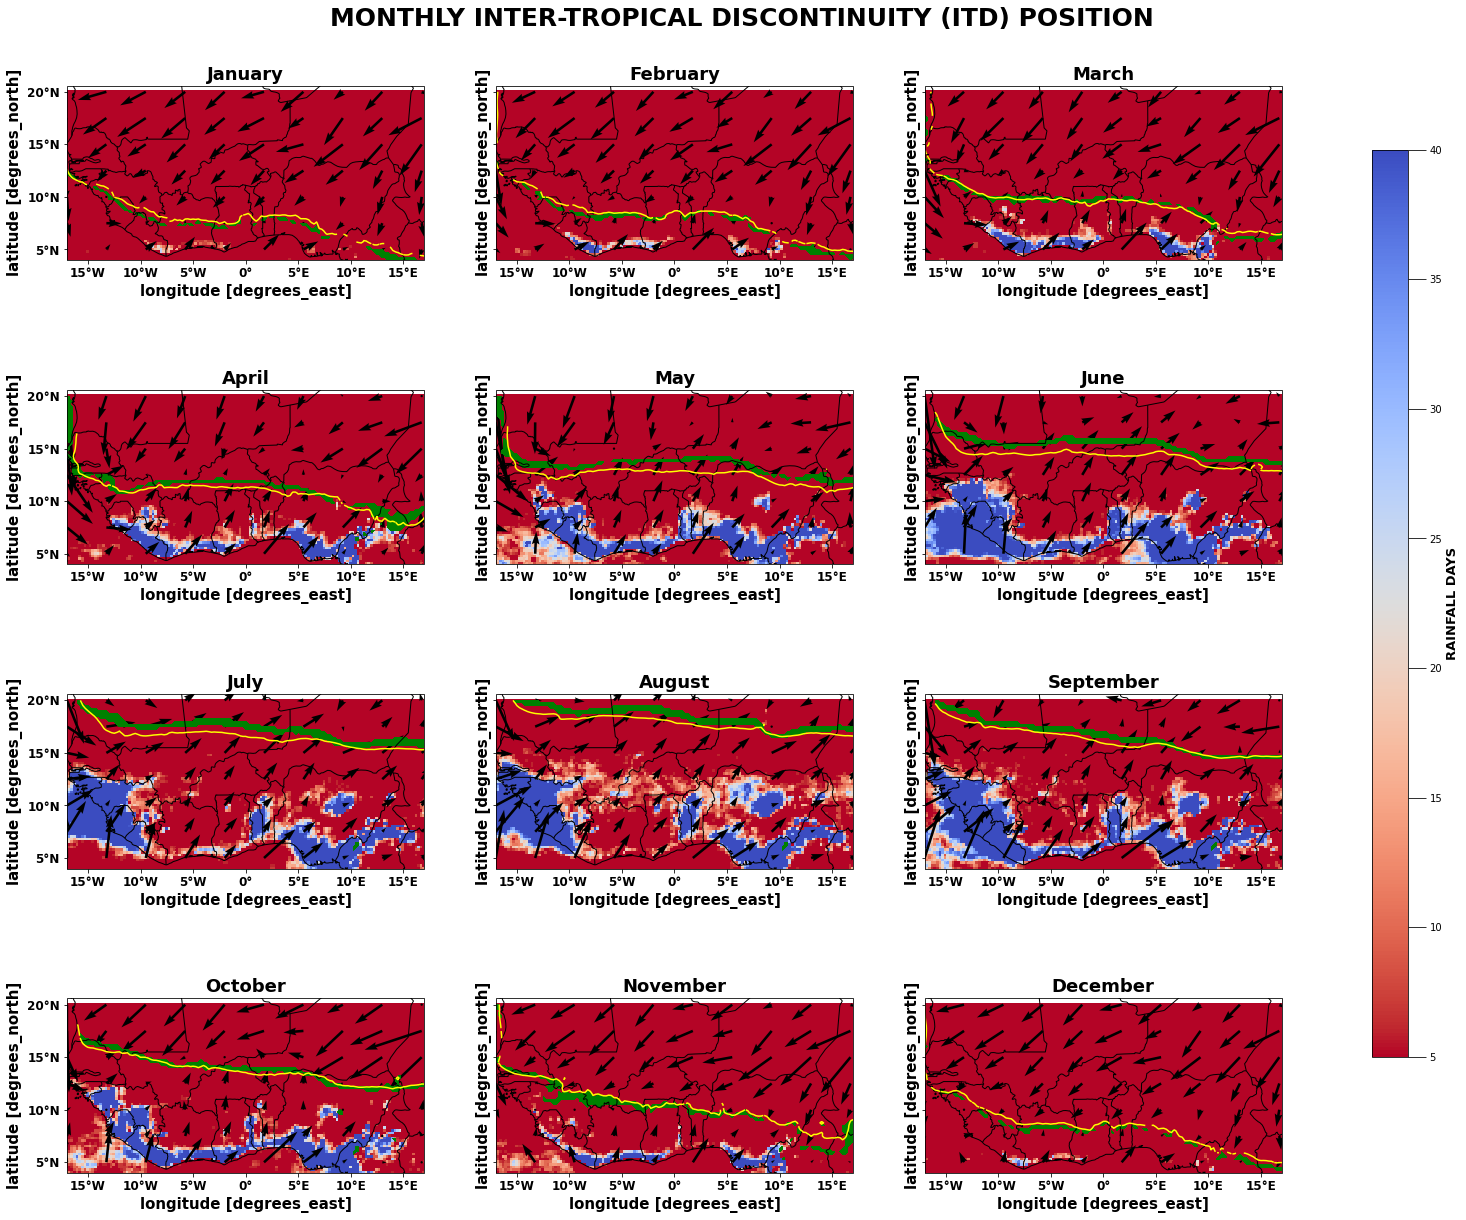

In [26]:
fig, axes = plt.subplots(nrows=4, ncols=3, subplot_kw = dict(projection = ccrs.PlateCarree()), 
                         figsize=(25,18), sharex = False, sharey = True )
plt.subplots_adjust(bottom=0.05, right=0.8, top=0.95)

ax = axes.flatten()

month = month = ['January', 'February', 'March', 'April','May', 'June', 'July', 
                 'August', 'September', 'October','November', 'December']

xlabels = (['-15','-10','-5','0','5','10','15'])
ylabels = (['20','15','10','5'])

for i, a in enumerate(ax):   
    ax[i].coastlines()
    ax[i].add_feature(cf.BORDERS)
    ax[i].set_extent([-17, 17, 4,20])
    ax[i].set_xticks([-15,-10,-5,0,5,10,15],  crs=ccrs.PlateCarree()) 
    ax[i].set_yticks([20,15,10,5], crs=ccrs.PlateCarree())
    ax[i].set_title(month[i], fontsize = 18, fontweight = 'bold')
    ax[i].set_xlabel('Longitude', fontsize = 15, fontweight = 'bold')
    ax[i].set_ylabel('Latitude', fontsize = 15, fontweight = 'bold')
    
   
    ax[i].set_xticklabels(xlabels, fontsize = 12, fontweight = 'bold')
    
    
    ax[i].set_yticklabels(ylabels, fontsize = 12, fontweight = 'bold')
    
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax[i].xaxis.set_major_formatter(lon_formatter)
    ax[i].yaxis.set_major_formatter(lat_formatter)
    
    
    
    #plotting the rainfall data
    tp = mon_tp_count[i].plot(cmap = 'coolwarm_r', vmax=40, vmin=5, ax = ax[i], add_colorbar = False)
    #tp=ax[i].contourf(mon_tp_count['longitude'], mon_tp_count['latitude'], mon_tp_count[i],vmax=20, vmin=5,
     #                 transform=ccrs.PlateCarree(), cmap='coolwarm_r',extend='both')

    
    #plotting the wind direction
    ww = ax[i].quiver(wind_direction_mon[i]['longitude'], wind_direction_mon[i]['latitude'], u_comp_mon[i], v_comp_mon[i])
    
    
    #plotting the ITD (Rel. Humidity)
    rh=ax[i].contour(rh_itd_mon['longitude'], rh_itd_mon['latitude'], rh_itd_mon[i],1, 
                      transform=ccrs.PlateCarree(), colors = ['yellow'])
    
    #plotting the ITD (Dewpoint)
    dp=ax[i].contourf(dewpoint_itd_mon['longitude'], dewpoint_itd_mon['latitude'], dewpoint_itd_mon[i],1,
                      transform=ccrs.PlateCarree(), colors = ['g'])
    
    
    ax[i].set_title(month[i], fontsize = 18, fontweight = 'bold')

fig.suptitle('MONTHLY INTER-TROPICAL DISCONTINUITY (ITD) POSITION', fontsize =25, fontweight = 'bold')        

#cbar_ax = fig.add_axes([0.16, 0.06, 0.6, 0.02])
cbar_ax = fig.add_axes([0.85, 0.17, 0.02, 0.7])
cbar=fig.colorbar(tp, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(size=18)
#cbar2.set_ticks([])
cbar.set_label( label = 'RAINFALL DAYS',size=13,weight='bold')
    
                      
#plt.savefig('monthly_itd+rainfall.pdf', dpi = 100)
#plt.savefig('monthly_itd+rainfall.png', dpi = 100)
#plt.savefig('monthly_itd+rainfall.jpg', dpi = 100)

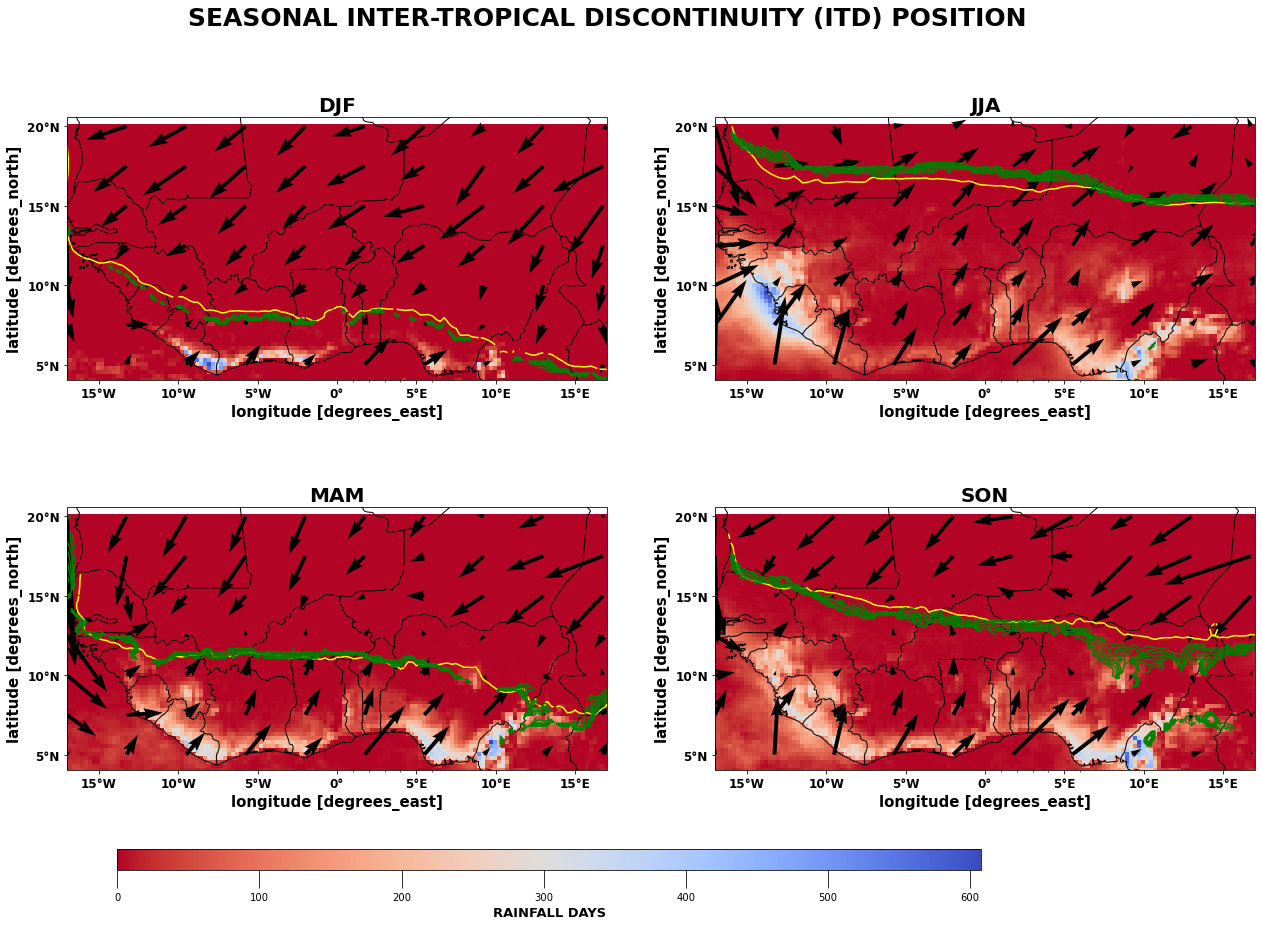

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw = dict(projection = ccrs.PlateCarree()), 
                         figsize=(20,15), sharex = False, sharey = False)
plt.subplots_adjust(bottom=0.25, right=0.95, top=0.9, hspace = 0.25)


ax = axes.flatten()

Titles = ['DJF', 'JJA', 'MAM', 'SON']
xlabels = (['-15','-10','-5','0','5','10','15'])
ylabels = (['20','15','10','5'])

for i, a in enumerate(ax):
    
    ax[i].coastlines()
    ax[i].add_feature(cf.BORDERS)
    ax[i].set_extent([-17, 17, 4,20])
    ax[i].set_xticks([-15,-10,-5,0,5,10,15],  crs=ccrs.PlateCarree()) 
    ax[i].set_yticks([20,15,10,5], crs=ccrs.PlateCarree())
    ax[i].set_title(Titles[i], fontsize = 20, fontweight = 'bold')
    
    ax[i].set_xticks(np.arange(1,7),1)
    ax[i].set_xticklabels(xlabels, fontsize = 12, fontweight = 'bold')
    
    #ax[i].set_yticks(np.arange(1,4),1)
    ax[i].set_yticklabels(ylabels, fontsize = 12, fontweight = 'bold')
    
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax[i].xaxis.set_major_formatter(lon_formatter)
    ax[i].yaxis.set_major_formatter(lat_formatter)
    
    ax[i].set_xlabel('Longitude', fontsize = 15, fontweight = 'bold')
    ax[i].set_ylabel('Latitude', fontsize = 15, fontweight = 'bold')
    
    
    
   
    #plotting the rainfall data
    tp = seas_tp_count[i].plot(cmap = 'coolwarm_r', ax = ax[i], add_colorbar = False)
    #p=ax[i].contourf(seas_tp['longitude'], seas_tp['latitude'], seas_tp[i],
     #                 transform=ccrs.PlateCarree(), cmap='coolwarm', extend = 'both')
     #tp = seas_tp[i].plot(cmap='bwr', ax = ax[i],vmax = 1500, vmin = 50 , add_colorbar = False)
    
    #plotting the wind direction
    ww = ax[i].quiver(wind_direction_seas[i]['longitude'], wind_direction_seas[i]['latitude'], u_comp_seas[i], v_comp_seas[i])
    
    #plotting the ITD (Rel. Humidity)
    rh=ax[i].contour(rh_itd_seas['longitude'], rh_itd_seas['latitude'], rh_itd_seas[i],1,
                      transform=ccrs.PlateCarree(), colors = ['yellow'])
    
    #plotting the ITD (Dewpoint)
    dp=ax[i].contour(dewpoint_itd_seas['longitude'], dewpoint_itd_seas['latitude'], dewpoint_itd_seas[i],
                      transform=ccrs.PlateCarree(), colors = ['green'])
    
    
    ax[i].set_title(Titles[i], fontsize = 20, fontweight = 'bold')
#axes[1,0].set_xlabel('Longitude', fontsize = 15, fontweight = 'bold')
#axes[1,1].set_xlabel('Longitude', fontsize = 15, fontweight = 'bold')
#axes[0,0].set_ylabel('Latitude', fontsize = 15, fontweight = 'bold')
#axes[1,0].set_ylabel('Latitude', fontsize = 15, fontweight = 'bold')

    
fig.suptitle('SEASONAL INTER-TROPICAL DISCONTINUITY (ITD) POSITION', fontsize =25, fontweight = 'bold')


cbar_ax = fig.add_axes([0.16, 0.18, 0.6, 0.02])
cbar=fig.colorbar(tp, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(size=18)
#cbar2.set_ticks([])
cbar.set_label( label = 'RAINFALL DAYS',size=13,weight='bold')

#plt.savefig('seasonal_itd+rainfall.pdf', dpi = 100)
#plt.savefig('seasonal_itd+rainfall.png', dpi = 100)
#plt.savefig('seasonal_itd+rainfall.jpg', dpi = 100)

# THE END 


# THANK YOU 🤝🤝🤝